# Paper Plots
This notebook is used to collect some of the code used to produce the plots particularly for the analysis note.

In [1]:
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import hist
from hist import Hist
import pickle
import mplhep as hep
import math
from tabulate import tabulate
import itertools
import warnings
import json
from plot_utils import *

warnings.filterwarnings('ignore')
hep.style.use("CMS")
plt.style.use(hep.style.CMS)
matplotlib.rcParams.update({'figure.max_open_warning': 0})
matplotlib.rcParams['figure.facecolor'] = 'white'

## Notebook Parameters
The following couple cells define the input and output directories, and load in the desired .pkl files into the `plots` nested dictionary.<br>
`output_label`: _str_, saves plots as `<output_label>+<plot_name>.<file_ext>`.<br>
`file_ext`: _str_, see above.<br>

In [2]:
# parameters
output_label = '/home/submit/lavezzo/public_html/SUEP/analysis/paper_plots/'
file_ext = '.pdf'

The `plots` dictionary is used to store all the plots imported from the pickle files. Dimensions: (sample) x (plot label) <br>
The `loader` function in `plot_utils.py` automatically merges all the QCD HT and QCD pT bins into one sample ('QCD_HT' and 'QCD_Pt'), applies the lumis, and excludes some of the low QCD bins.<br>

In [3]:
# create output dir
if not os.path.isdir(output_label): 
    print("Creating", output_label)
    os.mkdir(output_label)

# This part is meant to be flxeible, depending on what you want to import
# dimensions: (sample) x (plot label)

# input .pkl files
plotDir = '/work/submit/{}/SUEP/outputs/'.format(os.environ['USER'])
infile_names = glob.glob(plotDir+'*.pkl')

offline_files_SUEP = [f for f in infile_names if "7_20.pkl" in f and ('SUEP-m' in f)]
plots_SUEP = loader(offline_files_SUEP)
offline_files_2018 = [f for f in infile_names if "7_20.pkl" in f and ('20UL18' in f or 'Run2018' in f)]
plots_2018 = loader(offline_files_2018)
offline_files_2017 = [f for f in infile_names if "7_20.pkl" in f and ('20UL17' in f or 'Run2017' in f)]
plots_2017 = loader(offline_files_2017)
offline_files_2016 = [f for f in infile_names if "7_20.pkl" in f and ('20UL16' in f or 'Run2016' in f)]
plots_2016 = loader(offline_files_2016)

# put everything in one dictionary
plots = {}
for key in plots_SUEP.keys(): plots[key] = plots_SUEP[key]
for key in plots_2018.keys(): plots[key+"_2018"] = plots_2018[key]
for key in plots_2017.keys(): plots[key+"_2017"] = plots_2017[key]
for key in plots_2016.keys(): plots[key+"_2016"] = plots_2016[key]

In [4]:
### TEMPORARY I DON'T WANT THIS HERE

def applySUEPxsecs(plots):
    
    new_plots_dict = {}
    for sample, plot_dict in plots.items():
        if 'SUEP-m' not in sample:
            new_plots_dict[sample] = plot_dict
            continue
        
        mass = sample.split("SUEP-m")[1]
        mass = mass.split('-')[0]
        mass = str(mass)
        
        xsec = getXSection(mass, 2018, SUEP=True)
        
        new_plots_dict[sample] = {}
        for key, plot in plot_dict.items():
            new_plots_dict[sample][key] = plot * xsec
            
    return new_plots_dict
        
plots = applySUEPxsecs(plots)

These are all the samples loaded.

In [5]:
keys = list(plots.keys())
keys.sort()
for k in keys: print(k)

1000to1500_2016
1000to1500_2017
1000to1500_2018
100to200_2016
100to200_2017
100to200_2018
1500to2000_2016
1500to2000_2017
1500to2000_2018
2000toInf_2016
2000toInf_2017
2000toInf_2018
200to300_2016
200to300_2017
200to300_2018
300to500_2016
300to500_2017
300to500_2018
500to700_2016
500to700_2017
500to700_2018
50to100_2016
50to100_2017
50to100_2018
700to1000_2016
700to1000_2017
QCD_HT_2016
QCD_HT_2017
QCD_HT_2018
SUEP-m1000-darkPho
SUEP-m1000-darkPhoHad
SUEP-m1000-generic
SUEP-m125-darkPho
SUEP-m125-darkPhoHad
SUEP-m125-generic
SUEP-m125-generic-htcut
SUEP-m400-darkPho
SUEP-m400-darkPhoHad
SUEP-m400-generic
SUEP-m750-darkPho
SUEP-m750-darkPhoHad
SUEP-m750-generic
data_2016
data_2017
data_2018


In [6]:
default_colors = {
    'QCD': 'midnightblue',
    'QCD_HT_2016': 'midnightblue',
    'QCD_HT_2017': 'midnightblue',
    'QCD_HT_2018': 'midnightblue',
    'data': 'maroon',
    'SUEP-m1000-darkPho': 'red',
    'SUEP-m1000-darkPhoHad': 'red',
    'SUEP-m1000-generic': 'red',
    'SUEP-m750-darkPho': 'orange',
    'SUEP-m750-darkPhoHad': 'orange',
    'SUEP-m750-generic': 'orange',
    'SUEP-m400-darkPho': 'green',
    'SUEP-m400-darkPhoHad': 'green',
    'SUEP-m400-generic': 'green',
    'SUEP-m125-darkPho': 'cyan',
    'SUEP-m125-darkPhoHad': 'cyan',
    'SUEP-m125-generic': 'cyan',
    'SUEP-m125-generic-htcut' : 'magenta'
}

## 1D Comparison

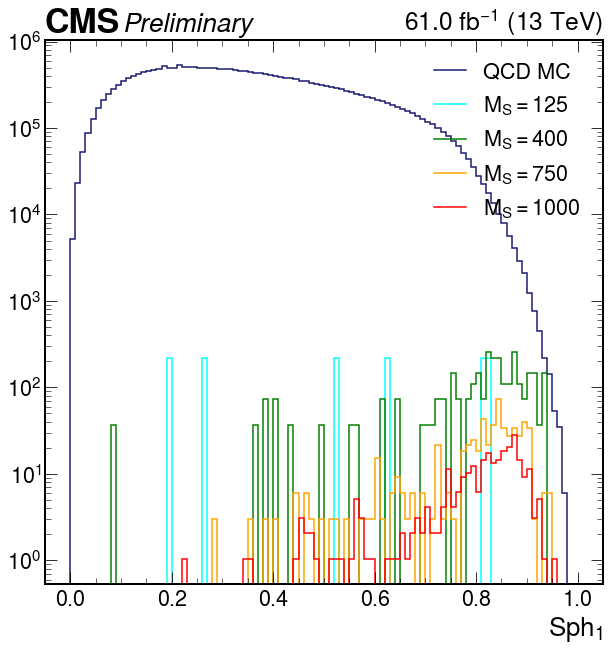

In [24]:
plot_label = 'SUEP_S1_Cluster'
samples = ['QCD_HT_2018', 'SUEP-m125-generic', 'SUEP-m400-generic', 'SUEP-m750-generic', 'SUEP-m1000-generic']
labels = ['QCD MC', r'$M_{S}=125$',r'$M_{S}=400$',r'$M_{S}=750$',r'$M_{S}=1000$']
density = False

fig, ax = plt.subplots(figsize=(10, 10))
hep.cms.label(llabel='Preliminary',data=False, lumi=61.0)

for label, sample in zip(labels, samples): 
    h = plots[sample][plot_label][::]
    if density: h = h/h.sum().value
    hep.histplot(h, yerr=False, label=label, color=default_colors[sample]) 

# tweak these by hand, as needed
# plt.ylim(1e4,1e6)
# plt.xlim(-1000,0 )
plt.legend()
plt.yscale("log")

# save and show
plt.savefig(output_label+plot_label+"_"+year+file_ext)
plt.show()

## Extended ABCD

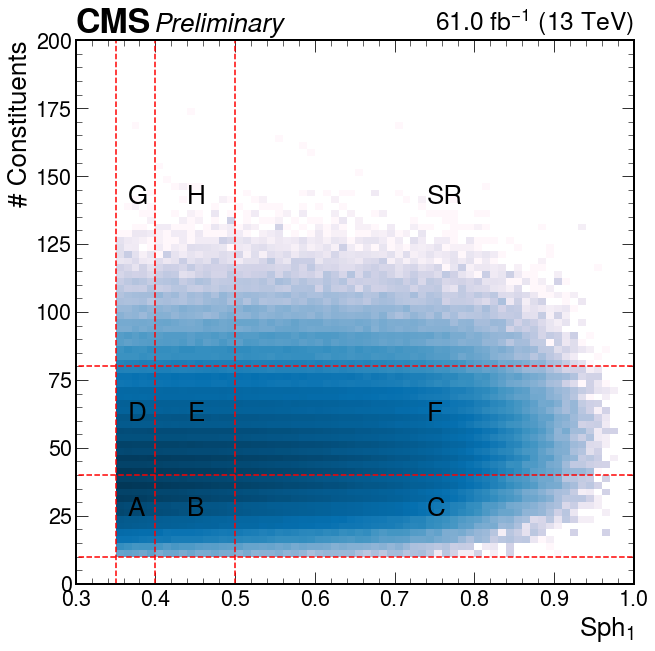

In [26]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster'
sample = 'QCD_HT_2018'
#samples += ['SUEP-m125-generic', 'SUEP-m400-generic', 'SUEP-m750-generic', 'SUEP-m1000-generic']
draw_lines = True
lines_x = [0.35,0.4, 0.5, 1.0]
lines_y = [10,40,80, 200]

fig, ax = plt.subplots(figsize=(10, 10))

k = 0
regions = ['A','B','C','D','E','F','G','H','SR']
for i in range(len(lines_y)-1):
    for j in range(len(lines_x)-1):
        xloc = (lines_x[j+1] + lines_x[j])/2 - 0.01
        yloc = (lines_y[i+1] + lines_y[i])/2
        plt.text(xloc, yloc, regions[k])
        k+=1
    
if plots[sample][plot_label].sum().value == 0:
    print("Histogram empty for sample", sample)

h = plots[sample][plot_label]
h = h[0.35j:,10j:]

hep.cms.label(llabel='Preliminary',data=False, lumi=61.0)
_ = hep.hist2dplot(h, 
           norm=matplotlib.colors.LogNorm(),
           cmap = 'PuBu',
           cbar=False,
           label=sample) 

# draw lines to visualize ABCD regions
if draw_lines:
    for y in lines_y: plt.plot([0,10000], [y,y], color='red', linestyle='dashed')
    for x in lines_x: plt.plot([x,x], [0,1000], color='red', linestyle='dashed')

# cms = fig.text(
#     55, 10., u"CMS $\it{preliminary}$",
#     fontsize=20, fontweight='bold',
# )
# lumi = fig.text(
#     164, 10., r"%.1f fb$^{-1}$ (13 TeV)" % 35.9,
#     fontsize=18, 
# )

plt.ylim(0,200)
plt.xlim(0.3,1.0)
plt.savefig(output_label+"extendedABCD_regions_2018"+file_ext)
plt.show()

## ABCD - QCD Background

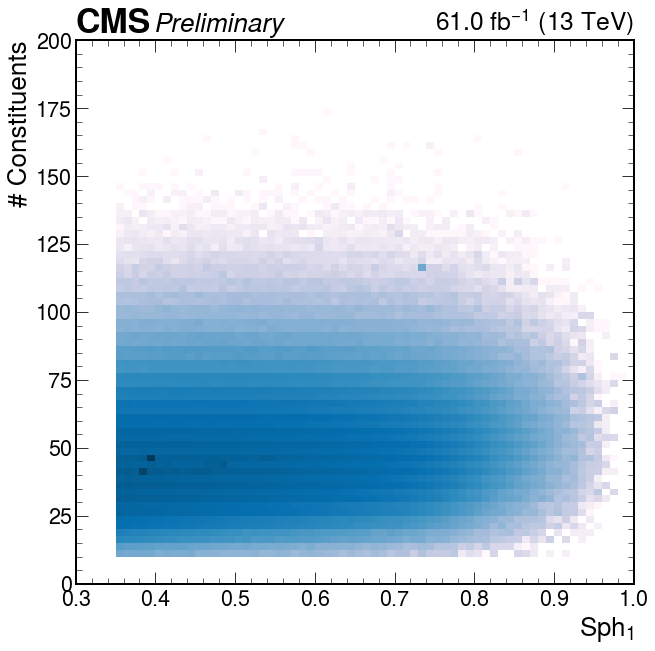

In [25]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster'
year = '2016'
sample = 'QCD_HT_'+year

fig, ax = plt.subplots(figsize=(10, 10))
    
if plots[sample][plot_label].sum().value == 0:
    print("Histogram empty for sample", sample)

h = plots[sample][plot_label]
h = h[0.35j:,10j:]

hep.cms.label(llabel='Preliminary',data=False, lumi=61.0)
_ = hep.hist2dplot(h, 
           norm=matplotlib.colors.LogNorm(),
           cmap = 'PuBu',
           cbar=False,
           label=sample) 

plt.ylim(0,200)
plt.xlim(0.3,1.0)
plt.savefig(output_label+"2D_decorrelate_"+year+file_ext)
plt.show()

## ABCD - MC Closure

Scaling factor alpha: 2.31069648984022
Sigma alpha: 0.0401209795655670


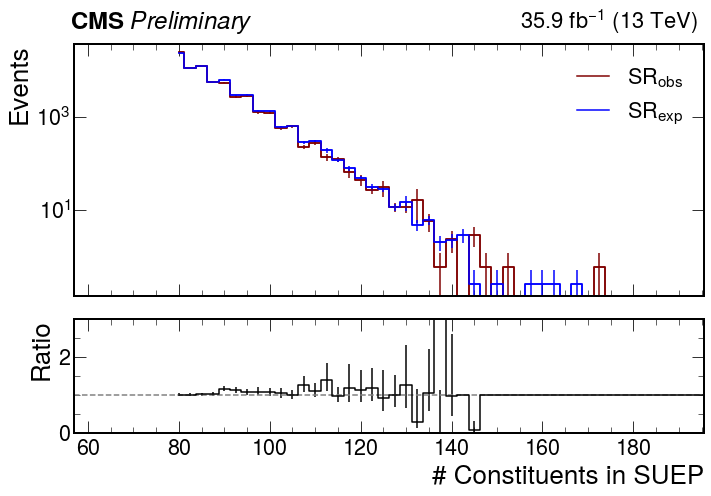

In [20]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster'
year = '2018'
abcd = plots['QCD_HT_'+year][plot_label]

# # 2D_SUEP_S1_SUEP_nconst_CL
A = abcd[0.35j:0.4j:sum,10.0j:40j]
B = abcd[0.35j:0.4j:sum,40j:80j]
C = abcd[0.35j:0.4j:sum,80j:300j]
D = abcd[0.4j:0.5j:sum,10.0j:40j]
E = abcd[0.4j:0.5j:sum,40j:80j]
F = abcd[0.4j:0.5j:sum,80j:300j]
G = abcd[0.5j:1.0j:sum,10.0j:40j]
H = abcd[0.5j:1.0j:sum,40j:80j]
SR = abcd[0.5j:1.0j:sum,80j:300j]

from sympy import symbols, diff, sqrt
import sympy

# define the scaling factor function
a, b, c, d, e, f, g, h = symbols('A B C D E F G H')
exp = h**2 * d**2 * b**2 * g**-1 * c**-1 * a**-1 * e**-4 * f**1

# defines lists of variables (sympy symbols) and accumulators (hist.sum())
variables = [a, b, c, d, e, f, g, h]
accs = [A.sum(), B.sum(), C.sum(),
        D.sum(), E.sum(), F.sum(),
       G.sum(), H.sum()]

# calculate scaling factor by substituting values of the histograms' sums for the sympy symbols
alpha = exp
for var, acc in zip(variables, accs):
    alpha = alpha.subs(var, acc.value)
    
# calculate the error on the scaling factor
sigma = 0
for var, acc in zip(variables, accs):
    der = diff(exp, var)
    var = abs(acc.variance)
    sigma += der**2 * var
for var, acc in zip(variables, accs):
    sigma = sigma.subs(var, acc.value)
sigma = sqrt(sigma)

print("Scaling factor alpha:", alpha)
print("Sigma alpha:", sigma)

# define SR_exp and propagate the error on the scaling factor to the bin variances
SR_exp = F.copy()
new_var = SR_exp.values()**2 * float(sigma)**2 + float(alpha)**2 * abs(SR_exp.variances())
SR_exp.view().variance = new_var
SR_exp.view().value = SR_exp.view().value * float(alpha)

# use the custom plot_ratio
# the hist implementation used elsewhere in the notebook doesn't use the 
# errors in the hists' bins to calculate the errors in the ratio plot
fig, axs, _ = plot_ratio(SR_exp, SR, 
                         "# Constituents in SUEP", "$SR_{obs}$", "$SR_{exp}$")
_ = axs[1].set_ylim(0,3.0)
_ = axs[0].legend()
cms = axs[0].text(
        56, 80000., u"CMS $\it{Preliminary}$",
        fontsize=24, fontweight='bold',
    )
lumi = axs[0].text(
        155, 80000., r"%.1f fb$^{-1}$ (13 TeV)" % 35.9,
        fontsize=22, 
    )
plt.savefig(output_label+"closure_"+year+file_ext)

## ABCD - Final

Scaling factor alpha: 2.31069648984022
Sigma alpha: 0.0401209795655670


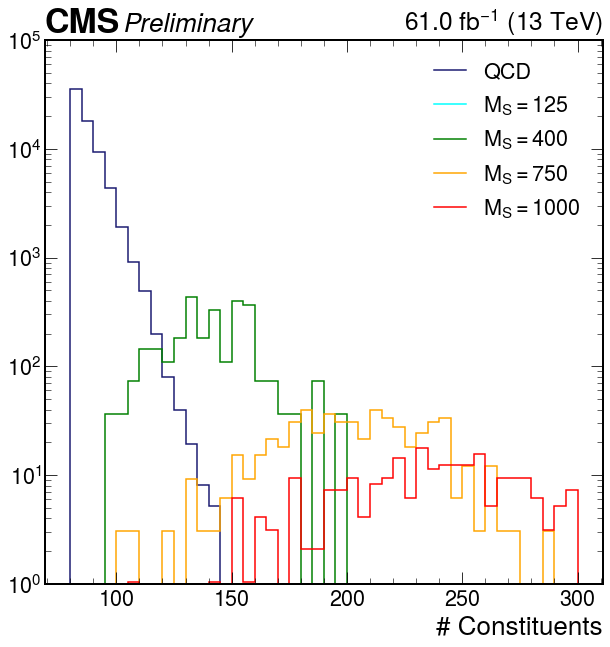

In [10]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster'
year = '2018'
abcd = plots['QCD_HT_'+year][plot_label]

# # 2D_SUEP_S1_SUEP_nconst_CL
A = abcd[0.35j:0.4j:sum,10.0j:40j]
B = abcd[0.35j:0.4j:sum,40j:80j]
C = abcd[0.35j:0.4j:sum,80j:300j]
D = abcd[0.4j:0.5j:sum,10.0j:40j]
E = abcd[0.4j:0.5j:sum,40j:80j]
F = abcd[0.4j:0.5j:sum,80j:300j:2j]
G = abcd[0.5j:1.0j:sum,10.0j:40j]
H = abcd[0.5j:1.0j:sum,40j:80j]
SR = abcd[0.5j:1.0j:sum,80j:300j:2j]

from sympy import symbols, diff, sqrt
import sympy

# define the scaling factor function
a, b, c, d, e, f, g, h = symbols('A B C D E F G H')
exp = h**2 * d**2 * b**2 * g**-1 * c**-1 * a**-1 * e**-4 * f**1

# defines lists of variables (sympy symbols) and accumulators (hist.sum())
variables = [a, b, c, d, e, f, g, h]
accs = [A.sum(), B.sum(), C.sum(),
        D.sum(), E.sum(), F.sum(),
       G.sum(), H.sum()]

# calculate scaling factor by substituting values of the histograms' sums for the sympy symbols
alpha = exp
for var, acc in zip(variables, accs):
    alpha = alpha.subs(var, acc.value)
    
# calculate the error on the scaling factor
sigma = 0
for var, acc in zip(variables, accs):
    der = diff(exp, var)
    var = abs(acc.variance)
    sigma += der**2 * var
for var, acc in zip(variables, accs):
    sigma = sigma.subs(var, acc.value)
sigma = sqrt(sigma)

print("Scaling factor alpha:", alpha)
print("Sigma alpha:", sigma)

# define SR_exp and propagate the error on the scaling factor to the bin variances
SR_exp = F.copy()
new_var = SR_exp.values()**2 * float(sigma)**2 + float(alpha)**2 * abs(SR_exp.variances())
SR_exp.view().variance = new_var
SR_exp.view().value = SR_exp.view().value * float(alpha)

# use the custom plot_ratio
# the hist implementation used elsewhere in the notebook doesn't use the 
# errors in the hists' bins to calculate the errors in the ratio plot
# fig, axs, _ = plot_ratio(SR_exp, SR, 
#                          "# Constituents in SUEP", "$SR_{obs}$ - QCD", "$SR_{exp}$ - Data")
# _ = axs[1].set_ylim(0,3.0)
# _ = axs[0].legend()

fig, ax = plt.subplots(figsize=(10, 10))
hep.cms.label(llabel='Preliminary',data=False, lumi=61.0)
hep.histplot(SR, yerr=False, label="SR - QCD", color=default_colors['QCD'])    
hep.histplot(SR_exp, yerr=False, label="Pred. SR - QCD", color=default_colors['data'])    

samples = ['SUEP-m125-generic', 'SUEP-m400-generic',
          'SUEP-m750-generic', 'SUEP-m1000-generic']
labels = [r'$M_{S}=125$',r'$M_{S}=400$',r'$M_{S}=750$',r'$M_{S}=1000$']
for sample, label in zip(samples, labels):
    abcd = plots[sample][plot_label]
    SUEP_SR = abcd[0.5j:1.0j:sum,80j:300j:2j]
    hep.histplot(SUEP_SR, yerr=False, label=label, color=default_colors[sample])    

plt.legend()
plt.yscale("log")
plt.ylim(1e0,1e5)
plt.savefig(output_label+"final_"+year+file_ext)

## ABCD - 1D Correlation

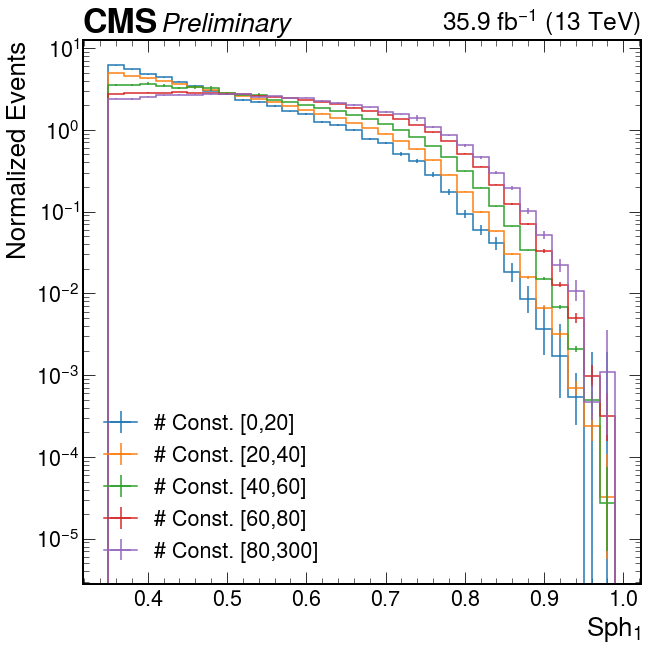

In [22]:
# parameters
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster'
sample = 'QCD_HT_2016'

fig, ax = plt.subplots(figsize=(10, 10))
hep.cms.label(llabel='Preliminary',data=False, lumi=35.9)

slices = [[0j,20j],[20j,40j],[40j,60j],[60j,80j],[80j,300j]]
for j in range(len(slices)):
    val_lo = slices[j][0]
    val_up = slices[j][1]

    h = plots[sample][plot_label][0.35j::2j,val_lo:val_up:sum]

    hep.histplot(h,
                 yerr=True, density=True, 
                 label="# Const. [{0},{1}]".format(round(val_lo.imag), round(val_up.imag)))    

plt.legend()
#plt.ylim(1e-6,1e0)
plt.yscale('log')
plt.ylabel("Normalized Events")
plt.xlabel(r"$Sph_{1}$")
plt.savefig(output_label + "1D_decorrelate_2016" + file_ext,  bbox_inches='tight')
plt.show()

## ABCD - data/MC Control Regions

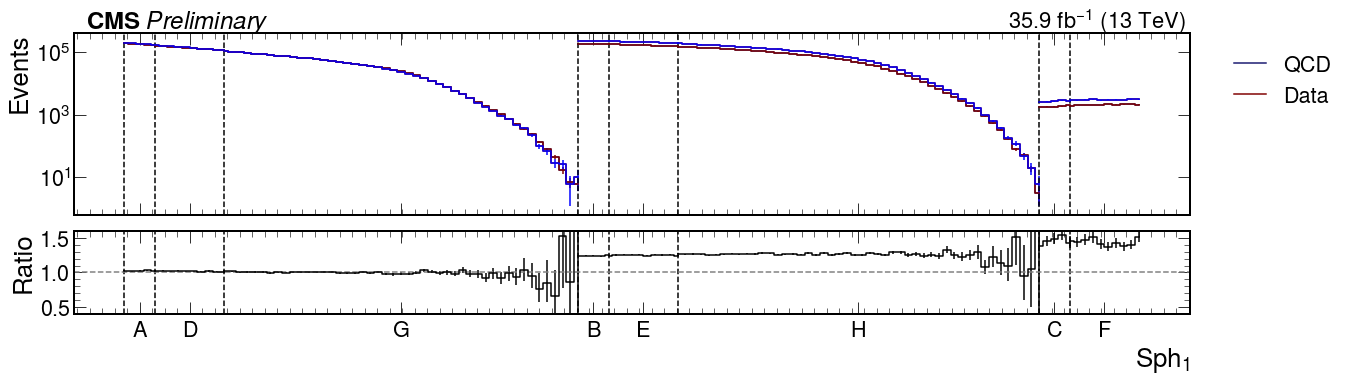

In [18]:
x = 'ABCDEFGH'
y = 'ADGBEHCF'
year = '2018'
plot_labels = ['SUEP_S1_Cluster']
for plot_label in plot_labels:
    fig, (ax1, ax2) = plot_ratio_regions(plots, 'A_'+plot_label, 
                           'data_'+year, 'QCD_HT_'+year, 
                           y, density=False)
    ax1.legend(labels=['QCD','Data'], loc='upper left', bbox_to_anchor=(1.02, 1))
    cms = ax1.text(
        -0.05, 600000., u"CMS $\it{Preliminary}$",
        fontsize=24, fontweight='bold',
    )
    lumi = ax1.text(
        1.15, 600000., r"%.1f fb$^{-1}$ (13 TeV)" % 35.9,
        fontsize=22, 
    )
    fig.savefig(output_label + 'control_regions_ratio_' + year + file_ext, bbox_inches='tight')

## ABCD - Contamination Control Regions

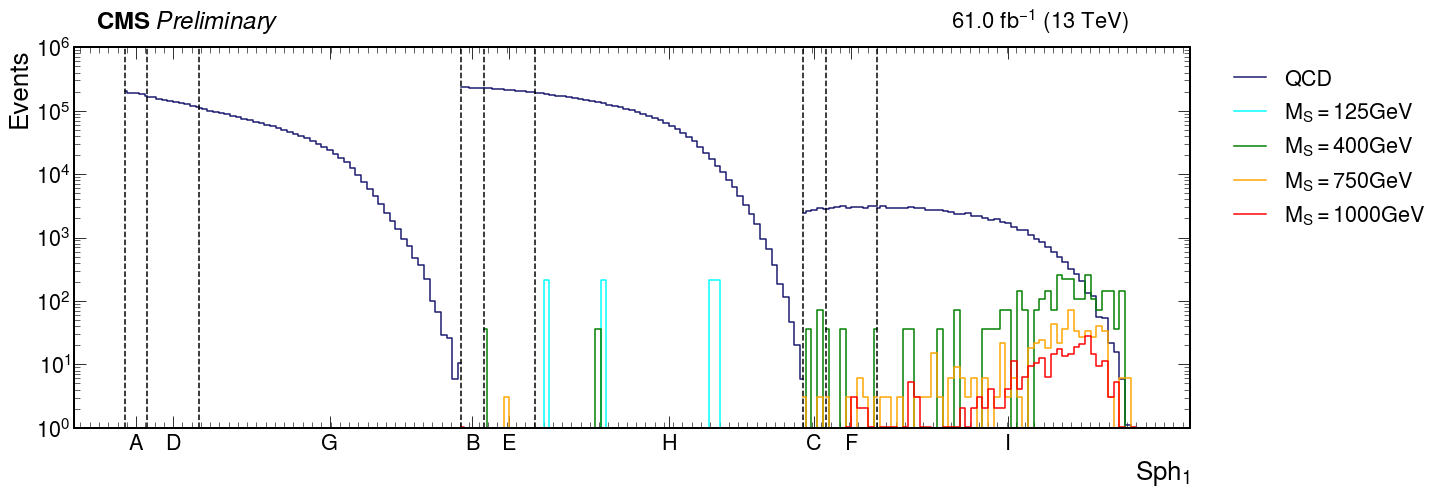

In [29]:
x = 'ABCDEFGH'
y = 'ADGBEHCFI'
year = '2018'
plot_labels = ['SUEP_S1_Cluster']
samples = ['QCD_HT_'+year, 'SUEP-m125-generic', 'SUEP-m400-generic',
          'SUEP-m750-generic', 'SUEP-m1000-generic']
labels = ['QCD', r'$M_{S} = 125 GeV$', r'$M_{S} = 400 GeV$',
          r'$M_{S} = 750 GeV$', r'$M_{S} = 1000 GeV$']
for plot_label in plot_labels:
    fig, ax = plot_all_regions(plots, 'A_'+plot_label, samples, 
                               labels=labels, regions=y, density=False)
    #ax.legend(labels=['QCD','Data'], loc='upper left', bbox_to_anchor=(1.02, 1))
    cms = ax.text(
        -0.05, 2000000., u"CMS $\it{Preliminary}$",
        fontsize=24, fontweight='bold',
    )
    lumi = ax.text(
        1.45, 2000000., r"%.1f fb$^{-1}$ (13 TeV)" % 61.0,
        fontsize=22, 
    )
    ax.set_ylim(1e0, 1e6)
    ax.set_xlabel(r"$Sph_1$")
    fig.savefig(output_label + 'contamination_' + year + file_ext, bbox_inches='tight')

## Contamination Table

In [24]:
plot_label = 'SUEP_nconst_Cluster'

samples = ['SUEP-m125-generic', 'SUEP-m400-generic',
          'SUEP-m750-generic', 'SUEP-m1000-generic']
labels = ['$m_{S} = 125 \GeV$', '$m_{S} = 400 \GeV$',
          '$m_{S} = 750 \GeV$', '$m_{S} = 1000 \GeV$']
regions = 'ABCDEFGH'

for year in ['2016', '2017', '2018']:
    QCD_sample = 'QCD_HT_'+year
    for label, sample in zip(labels, samples):
        line = label + ' & '
        for i, region in enumerate(regions):
            h = plots[sample][region + "_" + plot_label]
            total = h.sum().value
            line += '$' + str(round(total)) + '\\pm' + str(round(np.sqrt(total))) + '$'

            if i == len(regions)-1: line += ' \\\\'
            else: line += ' & '
        print(line)
    print()

$m_{S} = 125 \GeV$ & $0\pm0$ & $0\pm0$ & $0\pm0$ & $0\pm0$ & $0\pm0$ & $0\pm0$ & $0\pm0$ & $25\pm5$ \\
$m_{S} = 400 \GeV$ & $0\pm0$ & $0\pm0$ & $18\pm4$ & $0\pm0$ & $6\pm2$ & $18\pm4$ & $0\pm0$ & $6\pm2$ \\
$m_{S} = 750 \GeV$ & $0\pm0$ & $0\pm0$ & $12\pm3$ & $0\pm0$ & $6\pm2$ & $37\pm6$ & $0\pm0$ & $0\pm0$ \\
$m_{S} = 1000 \GeV$ & $0\pm0$ & $6\pm2$ & $0\pm0$ & $0\pm0$ & $0\pm0$ & $55\pm7$ & $0\pm0$ & $0\pm0$ \\

$m_{S} = 125 \GeV$ & $0\pm0$ & $0\pm0$ & $0\pm0$ & $0\pm0$ & $0\pm0$ & $0\pm0$ & $0\pm0$ & $25\pm5$ \\
$m_{S} = 400 \GeV$ & $0\pm0$ & $0\pm0$ & $18\pm4$ & $0\pm0$ & $6\pm2$ & $18\pm4$ & $0\pm0$ & $6\pm2$ \\
$m_{S} = 750 \GeV$ & $0\pm0$ & $0\pm0$ & $12\pm3$ & $0\pm0$ & $6\pm2$ & $37\pm6$ & $0\pm0$ & $0\pm0$ \\
$m_{S} = 1000 \GeV$ & $0\pm0$ & $6\pm2$ & $0\pm0$ & $0\pm0$ & $0\pm0$ & $55\pm7$ & $0\pm0$ & $0\pm0$ \\

$m_{S} = 125 \GeV$ & $0\pm0$ & $0\pm0$ & $0\pm0$ & $0\pm0$ & $0\pm0$ & $0\pm0$ & $0\pm0$ & $25\pm5$ \\
$m_{S} = 400 \GeV$ & $0\pm0$ & $0\pm0$ & $18\pm4$ & $0\pm0$ & $6\

In [28]:
for year in ['2016', '2017', '2018']:
    QCD_sample = 'QCD_HT_'+year
    for label, sample in zip(labels, samples):
        line = label + ' & '
        for i, region in enumerate(regions):
            h = plots[sample][region + "_" + plot_label]
            hQCD = plots[QCD_sample][region + "_" + plot_label]
            alpha = h.sum().value
            beta = hQCD.sum().value
            total = alpha/beta * 100
            err = np.sqrt(alpha * (beta**-2) + (alpha**2) * (beta**-3)) * 100
            line += '$' + str(round(total,2)) + '\\pm' + str(round(err,2)) + '$'

            if i == len(regions)-1: line += ' \\\\'
            else: line += ' & '
        print(line)
    print()

$m_{S} = 125 \GeV$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.0\pm0.0$ \\
$m_{S} = 400 \GeV$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.21\pm0.05$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.1\pm0.02$ & $0.0\pm0.0$ & $0.0\pm0.0$ \\
$m_{S} = 750 \GeV$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.14\pm0.04$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.19\pm0.03$ & $0.0\pm0.0$ & $0.0\pm0.0$ \\
$m_{S} = 1000 \GeV$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.28\pm0.04$ & $0.0\pm0.0$ & $0.0\pm0.0$ \\

$m_{S} = 125 \GeV$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.0\pm0.0$ \\
$m_{S} = 400 \GeV$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.2\pm0.05$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.09\pm0.02$ & $0.0\pm0.0$ & $0.0\pm0.0$ \\
$m_{S} = 750 \GeV$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.13\pm0.04$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.18\pm0.03$ & $0.0\pm0.0$ & $0.0\pm0.0$ \\
$m_{S} = 1000 \GeV$ & $0.0\pm0.0$ & $0.0\pm0